#### Homework 1

Consider a small bistatic continuous wave Doppler radar device similar to the one demonstrated in Lecture 1. This small radar has a frequency of 10.5 GHz, a transmitter power of 10 mW, an antenna gain of 9 dBi for both transmitting and receiving antennas, and a minimum detectable signal of -60 dBm.

### Coding Problem 1a

Write a short Python program to plot the maximum range of this radar as a function
of target RCS, for target RCS between 0.01 m² (approximating a bird), up to 100 m²
(approximating a car). Ensure that your turn-in PDF includes the source code and the
resulting plot.

In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
c = 3e8                              # Speed of light (m/s)
f = 10.5e9                           # Operating frequency (Hz)
Pt = 10e-3                           # Transmitter power (W)
G_dB = 9                             # Antenna gain (dBi)
G = 10**(G_dB/10)                    # Convert dBi to linear scale
Smin_dBm = -60                       # Minimum detectable signal (dBm)
Smin_W = 10**(Smin_dBm/10) / 1000    # Convert dBm to Watts

lambda_ = c / f                      # Wavelength (m)

In [61]:

sigma = np.logspace(-2,2,400)    # Radar cross section (m^2), 400 points from 0.01 to 100

R = ((Pt * G**2 * lambda_**2 * sigma) / ((4 * np.pi)**3 * Smin_W)) ** 0.25 # Radar range equation assuming G for TX/RX


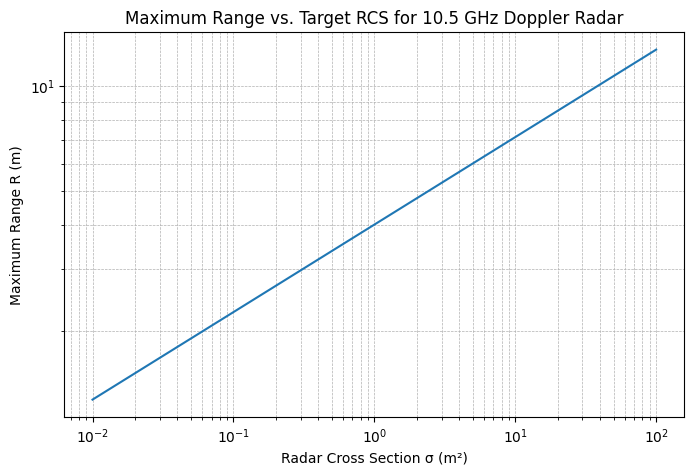

In [62]:
plt.figure(figsize=(8, 5))
plt.loglog(sigma, R)
plt.xlabel('Radar Cross Section σ (m²)')
plt.ylabel('Maximum Range R (m)')
plt.title('Maximum Range vs. Target RCS for 10.5 GHz Doppler Radar')
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.savefig('max_range_vs_rcs.pdf', dpi=300)
plt.show()

### Coding Problem 1b

A bicycle with RCS 2 m² moves away from the radar at an initial speed of 4.5 m/s and acceleration of 0.1 m/s², and at the same time a car with RCS 100 m² moves away from the radar at an initial speed of 26.8 m/s and an acceleration of 0.5 m/s². Both targets start 1 m from the radar and move away in a straight line.

Write a short program that produces a simulated sampled radar IF output as a .wav file. This .wav file should have a sampling rate of 8 kHz, using 16 bit samples, with a duration of 15 s. The simulator should model the changing Doppler frequencies due to the bike and the car, and should also model the change in strength of the radar return as the bike and car move away from the radar. Note, the "gain" of the radar receiver is not specified so please normalize the maximum valued sample to full-scale within the .wav file. Turn in your source code and the resulting .wav file.

In [63]:
# clear previous variables
%reset -f

import numpy as np
from scipy.io.wavfile import write

In [64]:
# Radar and simulation parameters

c = 3e8           # Speed of light (m/s)
f = 10.5e9        # Radar frequency (Hz)
lambda_r = c / f  # Wavelength (m)
fs = 8000         # Sampling rate (Hz)
duration = 15     # Duration (seconds)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)


# Bicycle parameters
sigma_bike = 2
v0_bike = 4.5
a_bike = 0.1

# Car parameters
sigma_car = 100
v0_car = 26.8
a_car = 0.5

In [65]:
x_bike = 1 + v0_bike * t + 0.5 * a_bike * t**2 # Initial distance + motion
x_car = 1 + v0_car * t + 0.5 * a_car * t**2 # Initial distance + motion

v_bike = v0_bike + a_bike * t # Velocity over time
v_car = v0_car + a_car * t # Velocity over time

fd_bike = 2 * v_bike / lambda_r
fd_car = 2 * v_car / lambda_r

amp_bike = sigma_bike / (x_bike**4) * 1e12
amp_car = sigma_car / (x_car**4) * 1e12

phi_bike = np.cumsum(2 * np.pi * fd_bike / fs)
phi_car = np.cumsum(2 * np.pi * fd_car / fs)

signal = amp_bike * np.sin(phi_bike) + amp_car * np.sin(phi_car) # Combine signals
signal = signal / np.max(np.abs(signal)) # Normalize to -1 to 1

write('radar_signal.wav', fs, (signal * 32767).astype(np.int16))

print(f"Signal length: {len(signal)} samples")
print(f"Expected length: {int(fs * duration)} samples")

print("Number of samples in signal:", len(signal))
print("Duration based on samples:", len(signal) / fs, "seconds")


Signal length: 120000 samples
Expected length: 120000 samples
Number of samples in signal: 120000
Duration based on samples: 15.0 seconds


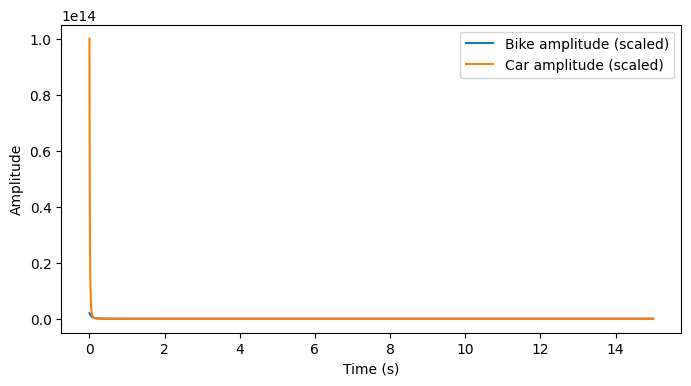

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(t, amp_bike, label="Bike amplitude (scaled)")
plt.plot(t, amp_car, label="Car amplitude (scaled)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


### Coding Problem 1c

Write a short program that ingests the .wav file produced above, and plots a spectrogram of the sampled radar IF signal. Turn in your source code and a PDF of the resulting plot. Be sure to label your axes appropriately!

In [67]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile


In [68]:
# Read .wav file
fs, radar_signal = wavfile.read('radar_signal.wav')

# Normalize to float for processing if 16-bit
if radar_signal.dtype == np.int16:
    radar_signal = radar_signal.astype(np.float32) / 32767

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


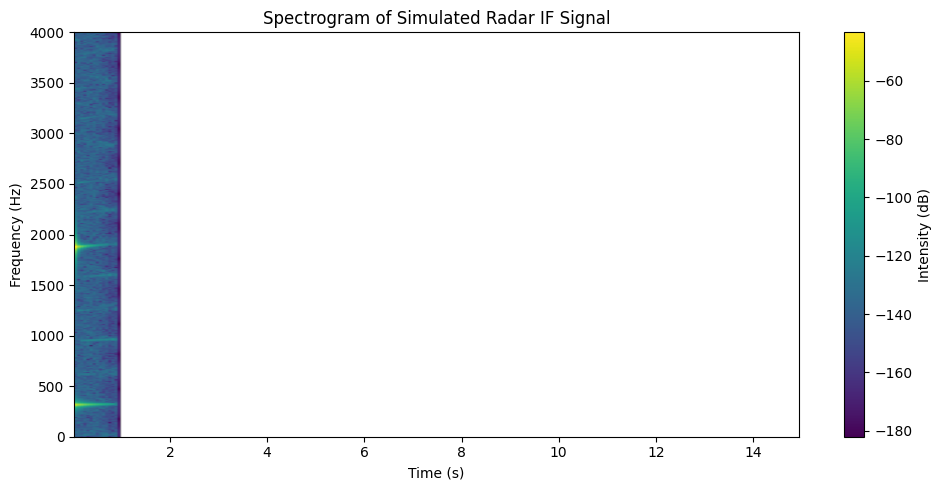

In [69]:
plt.figure(figsize=(10, 5))
plt.specgram(radar_signal, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')
plt.title('Spectrogram of Simulated Radar IF Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.tight_layout()
plt.savefig('radar_spectrogram.pdf')   # Save as PDF
plt.show()